### Title ###

In [1]:
import gym
import time
import enum
import numpy as np
import matplotlib.pyplot as plt
import warnings
from stable_baselines import DQN
warnings.filterwarnings('ignore')

water_density = 1025  # kg/m^3
shell_vol = 0.0088  # m^3, No fluid in bladder
bladder_max = 0.0002899  # Extra volume in m^3 from fully inflated bladder
mass = 9.17
bladder_steady_state = mass / water_density - shell_vol

c:\users\rlisu\anaconda3\envs\floatenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rlisu\anaconda3\envs\floatenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rlisu\anaconda3\envs\floatenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\rlisu\anaconda3\envs\floatenv\lib\site-packages\tensorf

In [2]:
class States(enum.Enum):
    No_Charge = 1
    Engine_Ramp_Up = 0
    Do_Nothing = 4
    Charge = 2
    
class FSMController:
    def __init__(self, steady_state, bladder_max):
        self.state = States.No_Charge
        self.steady_state = steady_state
        self.bladder_max = bladder_max
        
    def update(self, state):
        error = state[1] - state[2]
        bladder = state[0]
        if self.state is States.Engine_Ramp_Up:
            if bladder >= self.bladder_max: self.state = States.Do_Nothing
            if error > 0: self.state = States.Charge
        elif self.state is States.Charge:
            if bladder <= self.steady_state: self.state = States.No_Charge
        elif self.state is States.Do_Nothing:
            if error > 0: self.state = States.Charge
        else:
            if error < 0:
                self.state = States.Engine_Ramp_Up
   
    def get_action(self):
        return self.state.value % 3
    
class PDD2Controller:
    def __init__(self, env, weights):
        self.desired_state = np.array([bladder_steady_state, env.depth_goal, env.depth_goal, 0])
        self.weights = weights
    def act(self, obs):
        val = np.round(np.dot(weights, (self.desired_state - obs)))
        if val < 0:
            return 0
        elif val is 0:
            return 1
        else:
            return 2
        

170928.30530160424


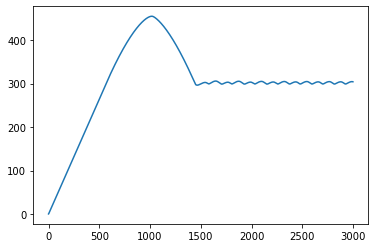

In [3]:
env = gym.make('float_env:float-v0', scale=600, random_start=False)
obs = env.reset()
x_axis = np.arange(env.end_time)
controller = FSMController(bladder_steady_state, bladder_max)
y_axis = np.array([])
x_axis = np.arange(3000)
state_goal = 300 * np.ones(3000)
while True:
    obs, reward, done, dic = env.step(controller.get_action())
    controller.update(obs)
    y_axis = np.append(y_axis, obs[2])
    if done:
        break
plt.plot(x_axis, y_axis)
print(np.sum(np.abs(y_axis - state_goal)))

150605.67102674936


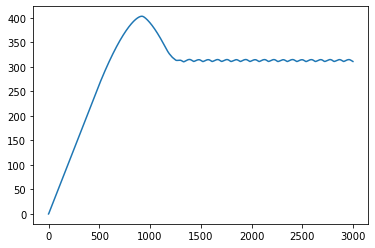

In [22]:
weights = np.array([-180000, 0, 1, 50])
obs = env.reset()
controller = PDD2Controller(env, weights)
y_axis = np.array([])
while True:
    obs, reward, done, dic = env.step(controller.act(obs))
    y_axis = np.append(y_axis, obs[2])
    if done:
        break
plt.plot(x_axis, y_axis)
print(np.sum(np.abs(y_axis - state_goal)))

In [10]:
dqn_model = DQN.load("dqn_float.zip")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


211507.28810094472


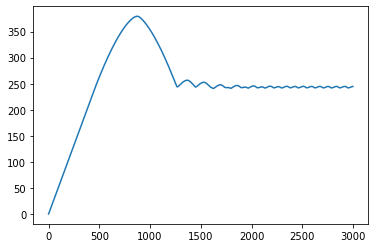

In [13]:
obs = env.reset()
y_axis = np.array([])
while True:
    action, states = dqn_model.predict(obs)
    obs, reward, done, dic = env.step(action)
    y_axis = np.append(y_axis, obs[2])
    if done:
        break
plt.plot(x_axis, y_axis)
print(np.sum(np.abs(y_axis - state_goal)))

In [14]:
dqn_model.save("dqn_float")